<a href="https://colab.research.google.com/github/Sypher003/BDA-mini-project/blob/main/bdamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing modules not related to Pyspark

In [ ]:
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

Importing Pyspark modules


In [ ]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
df = spark.read.csv('/content/Violence Against Women  Girls Data.csv',inferSchema=True, header=True)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,RecordID,Country,Gender,Demographics Question,Demographics Response,Question,Survey Year,Value
0,count,12600,12600,12600,12600,12600,12600,12600,11187
1,mean,210.5,None,None,None,None,None,None,19.76253687315632
2,stddev,121.24802439346753,None,None,None,None,None,None,16.986436699740587
3,min,1,Afghanistan,F,Age,15-24,... for at least one specific reason,01/01/2000,0.0
4,max,420,Zimbabwe,M,Residence,"Widowed, divorced, separated",... if she refuses to have sex with him,01/01/2018,86.9


There are total 12600 row, Let print first 2 data rows:


,RecordID,Country,Gender,Demographics Question,Demographics Response,Question,Survey Year,Value
0,1,Afghanistan,F,Marital status,Never married,... if she burns the food,01/01/2015,NaN
1,1,Afghanistan,F,Education,Higher,... if she burns the food,01/01/2015,10.1


In [ ]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,RecordID,int
1,Country,string
2,Gender,string
3,Demographics Question,string
4,Demographics Response,string
5,Question,string
6,Survey Year,string
7,Value,double


In [ ]:
string_columns = ['Country', 'Gender', 'Demographics Question', 'Demographics Response', 'Question', 'Survey Year']
numeric_columns = ['RecordID','Value']
missing_values = {} 
for index, column in enumerate(df.columns):
    if column in string_columns:
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,RecordID,Country,Gender,Demographics Question,Demographics Response,Question,Survey Year,Value
0,0,0,0,0,0,0,0,25


In [ ]:
df = df.withColumn('ViolenceRecordCount',col('RecordID'))

def Violence_record_summarize(df):
    victims_count = format(df.select('RecordID').distinct().count(), ',d')
    country_count = str(df.select('Country').distinct().count())
    sum_temp = df.agg(functions.sum('ViolenceRecordCount')).toPandas()
    total_records_count = format(sum_temp['sum(ViolenceRecordCount)'][0],',d')
    columns=['Victims count', 'Country types count', 'Total records count']
    data = [[victims_count], [country_count], [total_records_count]]
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]
    gender_user_count = df.select('Gender','RecordId').distinct().groupBy('Gender').count().toPandas()
    gender_activities_count = df.groupBy('Gender').count().toPandas()
    gender_user_activity_count = gender_user_count.join(
        gender_activities_count.set_index('Gender'), on='Gender'
        , how='inner', lsuffix='_gu'
    )
    gender_user_activity_count.columns = ['Gender', 'No. of users', 'Violence Record count']
    
    return sum_df, gender_user_activity_count

sum_dfs= Violence_record_summarize(df)
print('\nOverall data set summary on No of users, cases and number of records (pre-filtering):')
sum_dfs[0]


Overall data set summary on No of users, cases and number of records (pre-filtering):


,Victims count,Country types count,Total records count
0,420,70,"2,652,300"


In [ ]:
victims_per_country_df = df.select(df.RecordID, df.Country) \
    .groupBy(df.Country) \
    .count() \
    .orderBy("count", ascending=False)


highest_country_victims_df = victims_per_country_df.toPandas()
# highest_country_victims_df = victims_per_country_df.limit(5).toPandas()

# Rename column name : 'count' --> Users count
highest_country_victims_df.rename(columns = {'count':'Victims count'}, inplace = True)
# Caculate the total users, we will this result to compute percentage later
total_Victims = victims_per_country_df.groupBy().sum().collect()[0][0]

victims_per_country_df.collect()
# victims_per_country_df.collect()[:5]

[Row(Country='Chad', count=180),
 Row(Country='Yemen', count=180),
 Row(Country='Congo Democratic Republic', count=180),
 Row(Country='Senegal', count=180),
 Row(Country='Guyana', count=180),
 Row(Country='Eritrea', count=180),
 Row(Country='Philippines', count=180),
 Row(Country='Turkey', count=180),
 Row(Country='Malawi', count=180),
 Row(Country='Comoros', count=180),
 Row(Country='Afghanistan', count=180),
 Row(Country='Cambodia', count=180),
 Row(Country='Jordan', count=180),
 Row(Country='Maldives', count=180),
 Row(Country='Rwanda', count=180),
 Row(Country='Togo', count=180),
 Row(Country='Angola', count=180),
 Row(Country='Lesotho', count=180),
 Row(Country='Albania', count=180),
 Row(Country='Madagascar', count=180),
 Row(Country='Ghana', count=180),
 Row(Country='Myanmar', count=180),
 Row(Country='Nicaragua', count=180),
 Row(Country='Benin', count=180),
 Row(Country='Peru', count=180),
 Row(Country='Sierra Leone', count=180),
 Row(Country='India', count=180),
 Row(Country=

Top 5 Countries that have the most Victims:


,Country,Victims count,percentage
0,Chad,180,1.428571
1,Yemen,180,1.428571
2,Congo Democratic Republic,180,1.428571
3,Senegal,180,1.428571
4,Guyana,180,1.428571
...,...,...,...
65,South Africa,180,1.428571
66,Colombia,180,1.428571
67,Pakistan,180,1.428571
68,Moldova,180,1.428571


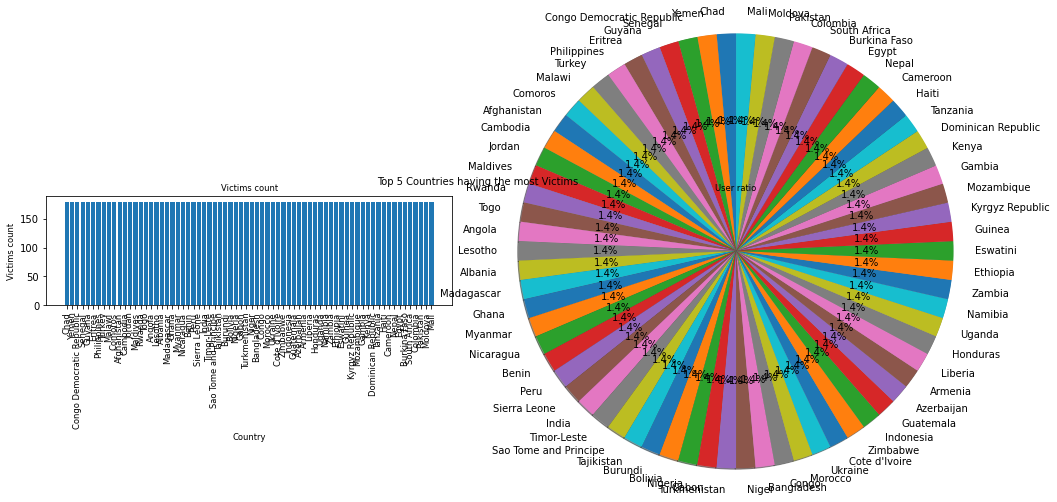

In [ ]:
highest_country_victims_df_renamed = highest_country_victims_df
# Compute the percentage of top 5 workout type / total users
highest_country_victims_df_renamed['percentage'] = highest_country_victims_df['Victims count'] \
    / total_Victims * 100

# We assign the rest of users belong to another specific group that we call 'others'
# others = {
#       'Country': 'others'
#     , 'Victims count': total_Victims - sum(highest_country_victims_df_renamed['Victims count'])
#     , 'percentage': 100 - sum(highest_country_victims_df_renamed['percentage'])
# }

# highest_country_victims_df_renamed = highest_country_victims_df_renamed.append(others, ignore_index=True)
print('Top 5 Countries that have the most Victims:')
highest_country_victims_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.05))

plot0 =   axs[0].bar(x=highest_country_victims_df_renamed['Country']
                     , height=highest_country_victims_df_renamed['Victims count'])
title0 =  axs[0].set_title('Victims count', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Country', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Victims count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_country_victims_df_renamed['Country'] 
                                       ,rotation = 'vertical', fontsize='small')
# explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=highest_country_victims_df_renamed['percentage']
    , labels=highest_country_victims_df_renamed['Country']
    , autopct='%1.1f%%', shadow=True, startangle=90
    , radius=5
)

text = fig.text(0.5, 1.02, 'Top 5 Countries having the most Victims', ha='center', va='top', transform=fig.transFigure)